## ORGANS: Data Cleaning Checks

This notebook contains analysis of the raw data used for this investigation to inform our data cleaning process. We also perform checks on the cleaned data for validation of the cleaning process.

---

### Initialize environment

In [2]:
library(tidyverse)
library(janitor)
library(lubridate)

In [3]:
root_path     <- here::here()
data_path     <- paste0(root_path, "/01_data")
analysis_path <- paste0(root_path, "/02_analysis")

---

### Analysis: Identify relevant discrepencies between `institution` and `institution.latlng` data

These two datasets will complement one another and they share similar data (e.g., ZIP code). We will use these two datasets together to identify the latitude/longitude for candidates and do so by merging on ZIP. This chunk of analysis identifies any instances where the ZIP code does not align between the two datasets for relevant hospitals.

In [4]:
institution.raw <- as_tibble(read.csv("raw/01_hospitals/22F138_Institution.csv"))

In [5]:
institution.latlng.raw <- as_tibble(read.csv("raw/01_hospitals/DONORHOSPITAL_22F168Records(2of3)-redacted.csv"))

In [6]:
candidate.raw <- as_tibble(read.csv("raw/02_candidate/Updated_CAN_LIIN_22F218Records(1of2)-redacted.csv"))

In [7]:
# 1) remove any instances where institution aligns already with institution.latlng based on PROVIDER_NUM + ZIP
#    [first cleaning the ZIPs to align in format]
institution.check <- anti_join(institution.raw %>%
                                    mutate(PRIMARY_ZIP = substr(str_pad(PRIMARY_ZIP, 5, "left", 0), 1, 5)),
                                institution.latlng.raw %>%
                                    mutate(HOSPITAL_ZIP = str_pad(HOSPITAL_ZIP, 5, "left", "0")),
                                by = c("PROVIDER_NUM", "PRIMARY_ZIP" = "HOSPITAL_ZIP")) %>%

    # merge on information from institution.latlng for the remaining instances, this time just using PROVIDER_NUM
    left_join(institution.latlng.raw %>% mutate(HOSPITAL_ZIP = str_pad(HOSPITAL_ZIP, 5, "left", "0")),
              by = c("PROVIDER_NUM")) %>%

    # limit to instances where the CTR_ID actually appears in the candidate datasets
    inner_join(candidate.raw %>% distinct(CTR_ID = CAN_LISTING_CTR_ID),
               by = "CTR_ID") %>%

    # limit to instances where there are ZIP codes from both sources to disagree on
    filter(!is.na(PRIMARY_ZIP), !is.na(HOSPITAL_ZIP)) %>%

    select(CTR_ID, CTR_TY, ENTIRE_NAME, PRIMARY_CITY, PRIMARY_STATE, PRIMARY_ZIP, PROVIDER_NUM,
           HOSPITAL_ZIP, LATITUDE, LONGITUDE)

In [8]:
institution.check %>% distinct(across(-matches("LATITUDE|LONGITUDE")), .keep_all = T)

CTR_ID,CTR_TY,ENTIRE_NAME,PRIMARY_CITY,PRIMARY_STATE,PRIMARY_ZIP,PROVIDER_NUM,HOSPITAL_ZIP,LATITUDE,LONGITUDE
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
159,TX1: Transplant Hospital,Hawaii Medical Center East,Honolulu,HI,96820,120010,96817,21.33485,-157.85670
206,TX1: Transplant Hospital,University of Kansas Hospital,Kansas City,KS,66103,170040,66160,39.05615,-94.61062
225,TX1: Transplant Hospital,Lindy Boggs Medical Center,New Orleans,LA,70119,190135,70115,29.93725,-90.10344
296,TX1: Transplant Hospital,Lahey Clinic Medical Center,Burlington,MA,01805,220171,01803,42.48404,-71.20471
305,TX1: Transplant Hospital,UMass Memorial Medical Center,Worcester,MA,01655,220163,01605,42.27864,-71.75908
651,TX1: Transplant Hospital,University Medical Center,Lubbock,TX,79408,450686,79415,33.58822,-101.89065
782,TX1: Transplant Hospital,VA Pittsburgh Healthcare System,Pittsburgh,PA,15240,39012F,15213,40.44744,-79.95934


There are seven instances of a candidate hospital where the ZIPs misalign between `institution` and `institution.latlng`. Below are notes determining which ZIP is correct.

1. `CTR_ID` = 159, `PROVIDER_NUM` = 120010 (Hawaii Medical Center East in Honolulu, HI) => correct ZIP of 96817 ([source](https://www.ahd.com/free_profile/120010/Hawaii_Medical_Center_East/Honolulu/Hawaii/))
2. `CTR_ID` = 206, `PROVIDER_NUM` = 170040 (University of Kansas Hospital in Kansas City, KS) => correct ZIP of 66160 ([source](https://www.kansashealthsystem.com/locations/main-campus-main-hospital-kansas-city-ks))
3. `CTR_ID` = 225, `PROVIDER_NUM` = 190135 (Lindy Boggs Medical Center in New Orleans, LA) => correct ZIP of 70119 ([source](https://www.countyoffice.org/lindy-boggs-medical-center-new-orleans-la-fde/))
4. `CTR_ID` = 296, `PROVIDER_NUM` = 220171 (Lahey Clinic Medical Center in Burlington, MA) => correct ZIP of 01805 ([source](https://www.lahey.org/location/lahey-hospital-medical-center/))
5. `CTR_ID` = 305, `PROVIDER_NUM` = 220163 (UMass Memorial Medical Center in Worcester MA) => correct ZIP of 01655 ([source](https://www.ahd.com/free_profile/220163/UMass_Memorial_Medical_Center_-_University_Campus/Worcester/Massachusetts/))
6. `CTR_ID` = 651, `PROVIDER_NUM` = 450686 (University Medical Center in Lubbock, TX) => correct ZIP of 79415 ([source](https://www.ahd.com/free_profile/450686/University_Medical_Center/Lubbock/Texas/))
7. `CTR_ID` = 782, `PROVIDER_NUM` = 39012F (VA Pittsburgh Healthcare System in Pittsburgh, PA) => correct ZIP of 15240 ([source](https://www.va.gov/pittsburgh-health-care/locations/pittsburgh-va-medical-center-university-drive/))

---

### Analysis: Comparison of transplant counts by state + year across sources

To check the validity of our cleaned data, this analysis compares the total transplant counts found via: (1) cleaned [National OPTN data download](https://optn.transplant.hrsa.gov/data/view-data-reports/national-data/) (`optn_tx_counts`) and (2) cleaned `transplant` data.

The National OPTN data was downloaded from "OPTN National Data" for Liver Transplants, aggregated by Center State and Recipient Age.

In [9]:
# import datasets used for comp
state_code_mapping <- read.csv("raw/00_misc/state_code_mapping_20221022.csv")

transplant <- readRDS("clean/transplant_clean.rds")

optn_tx_counts <- readRDS("clean/optn_tx_counts_clean.rds")

In [10]:
# merge together aggregated counts across sources for comp
tx.comp <- optn_tx_counts %>%
  filter(CENTER_STATE != "All Center States",
         YEAR %in% 2018:2021,
         REC_AGE %in% c("18-34 Years", "35-49 Years", "50-64 Years", "65 +", "Unknown")) %>%
  count(YEAR, CENTER_STATE, wt = TX, name = "TX_OPTN_ADULTS") %>%
  left_join(state_code_mapping, by = c("CENTER_STATE" = "STATE_NAME")) %>%
  select(YEAR, STATE = STATE_CODE, TX_OPTN_ADULTS) %>%
  full_join(transplant %>% 
              filter(REC_TX_DT_YEAR %in% 2018:2021,
                     !is.na(CAN_HOSPITAL_STATE)) %>% 
              count(YEAR = REC_TX_DT_YEAR, STATE = CAN_HOSPITAL_STATE, name = "TX_SRTR_TX"),
            by = c("STATE", "YEAR")) %>%
  mutate(across(matches("TX_"), replace_na, replace = 0),
         IS_DIFF = TX_OPTN_ADULTS != TX_SRTR_TX,
         DIFF = abs(TX_OPTN_ADULTS - TX_SRTR_TX)) %>%
  arrange(STATE, YEAR)

write.csv(tx.comp, "output/tables/table1-transplant_source_comp.csv", row.names = F)

tx.comp %>% head()

YEAR,STATE,TX_OPTN_ADULTS,TX_SRTR_TX,IS_DIFF,DIFF
<dbl>,<chr>,<dbl>,<int>,<lgl>,<dbl>
2018,AL,119,119,FALSE,0
2019,AL,128,128,FALSE,0
2020,AL,97,97,FALSE,0
2021,AL,72,72,FALSE,0
2018,AR,37,37,FALSE,0
2019,AR,43,43,FALSE,0


In [11]:
tx.comp %>%
  filter(IS_DIFF)

YEAR,STATE,TX_OPTN_ADULTS,TX_SRTR_TX,IS_DIFF,DIFF
<dbl>,<chr>,<dbl>,<int>,<lgl>,<dbl>
2021,IL,341,340,TRUE,1
2021,NY,603,602,TRUE,1
2020,PA,554,553,TRUE,1
2021,PA,507,505,TRUE,2


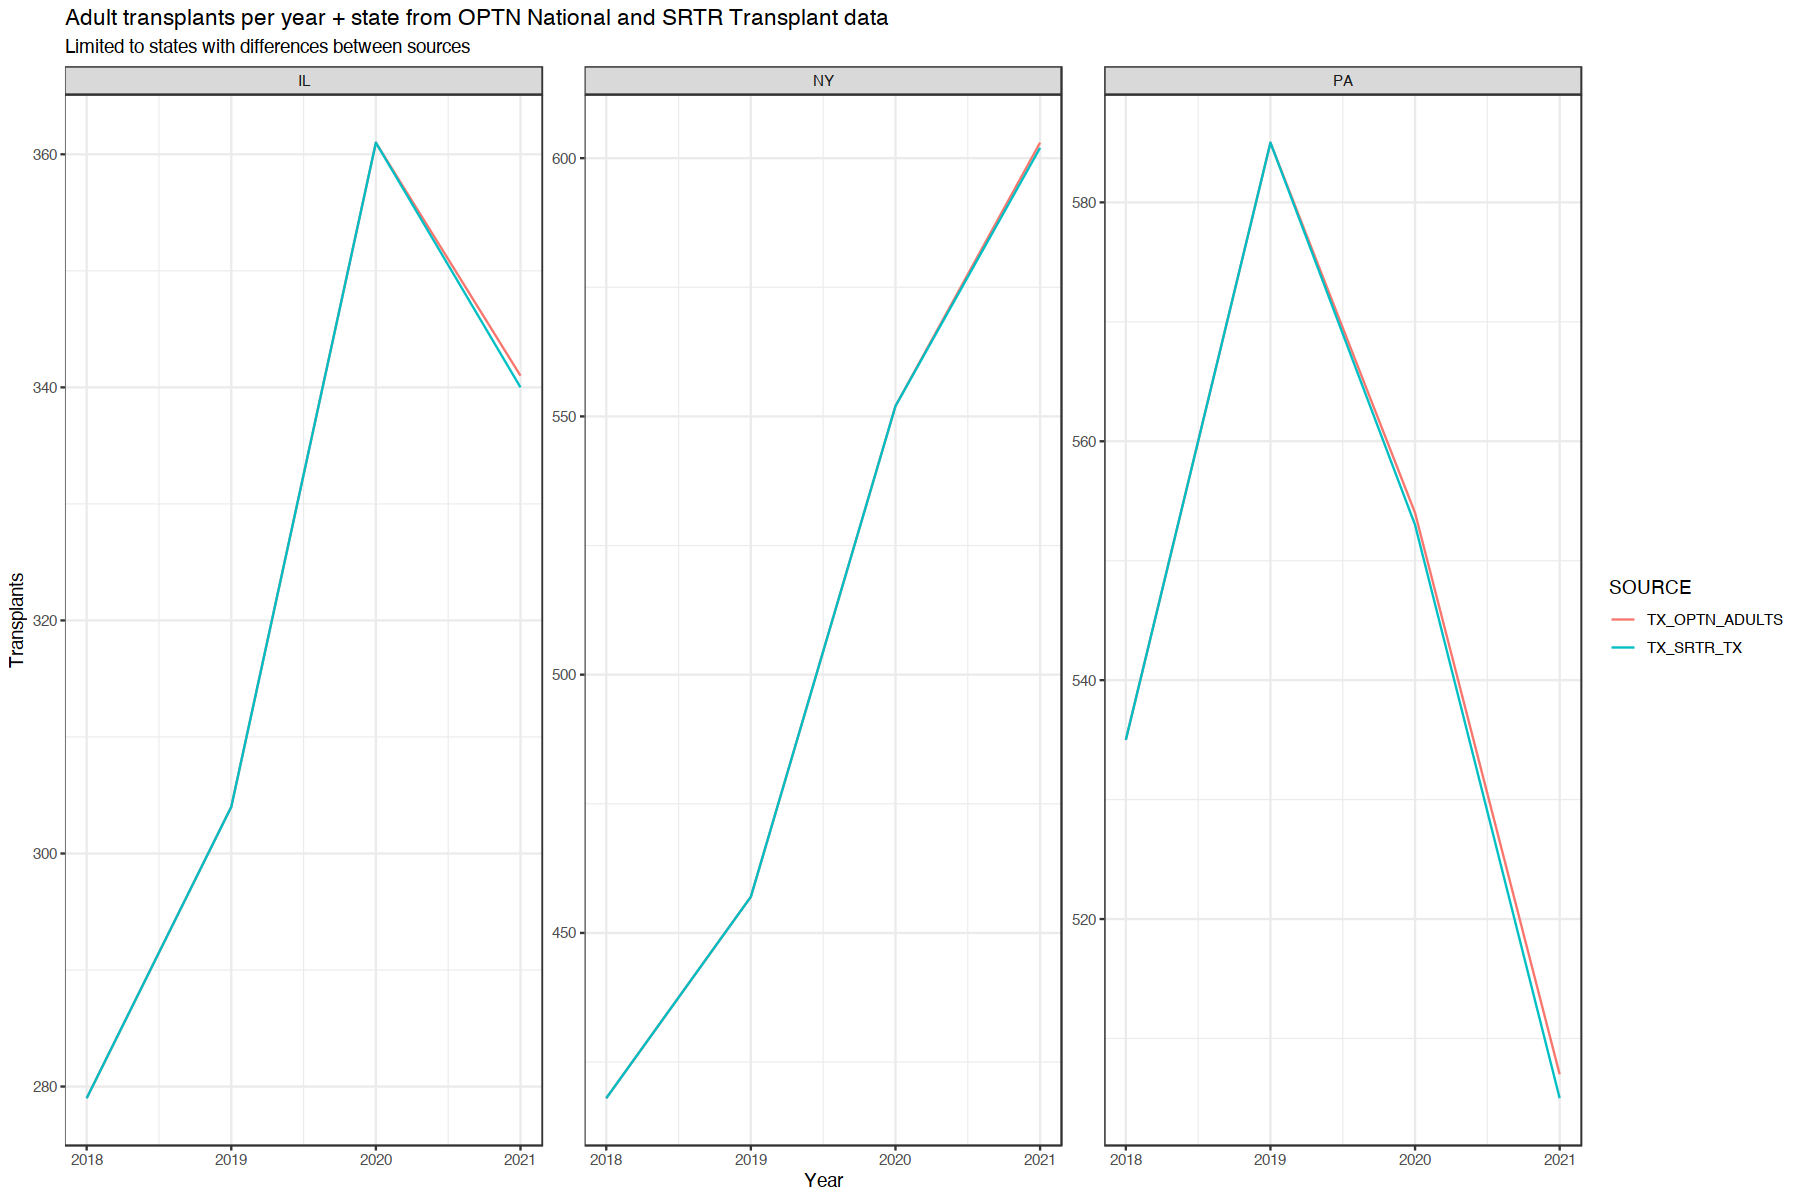

In [12]:
options(repr.plot.width = 15, repr.plot.height = 10)

tx.comp.plot <- tx.comp %>%
  group_by(STATE) %>%
  filter(max(as.numeric(IS_DIFF)) == 1) %>%
  ungroup() %>%
  pivot_longer(matches("TX_"), names_to = "SOURCE", values_to = "VALUE") %>%
  ggplot(aes(x = YEAR, y = VALUE, color = SOURCE)) +
  geom_line() +
  scale_x_continuous(name = "Year") +
  scale_y_continuous(name = "Transplants") +
  facet_wrap(~ STATE, scales = "free_y") +
  labs(title = "Adult transplants per year + state from OPTN National and SRTR Transplant data",
       subtitle = "Limited to states with differences between sources") +
  theme_bw()

ggsave("output/figures/fig1-transplant_count_comp.png", tx.comp.plot, device = "png",
       width = 15, height = 10)

tx.comp.plot

In [13]:
tx.comp %>% group_by(YEAR) %>% summarise(across(matches("TX_"), sum, na.rm = T))

YEAR,TX_OPTN_ADULTS,TX_SRTR_TX
<dbl>,<dbl>,<int>
2018,7687,7687
2019,8345,8345
2020,8404,8403
2021,8735,8731
